# Final Exam/Project -- Applied Machine Learning

Josh Gregory

## Algorithm Selection

The first classification algorithm that will be used is an SVM. The second will be a convolutional neural network (CNN).

I am going to implement $k$-fold cross-validation, and as such, will be combining the given dataset splits into one dataset.

## SVM Implementation

### Pre-Processing

Unlike CNNs, SVMs cannot take in raw image data. Therefore, we will need to pre-process the data into tensors manually before feeding it into the SVM.

In [24]:
from IPython.display import Image
%matplotlib inline

# importing the necessary libraries
import os
import pickle
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn import tree, preprocessing
from sklearn.utils import shuffle
import seaborn as sns

sns.set()

## Image pre-processing pipeline

The function `pre_process_image` will take in the entire data directory, and walk through each color (red, yellow, and green). For each file within each color, it will read in the image, crop it, than append it to the NumPy array called "features". The corresponding label will also be appended to a NumPy array called "labels".

In [25]:
# !pip install opencv-python

def pre_process_images(data_directory):
    features = []
    labels = []

    for color in ['red', 'yellow', 'green']:
        color_path = os.path.join(data_directory, color)

        # Get all files in color directory

        for file in os.listdir(color_path):
            img_path = os.path.join(color_path, file)
                
            # Read in image
            img = cv2.imread(img_path)

            image_crop = np.copy(img)
            row_crop = 7
            col_crop = 8
            image_crop = img[row_crop:-row_crop, col_crop:-col_crop, :]

            img_resized = cv2.resize(image_crop, (32, 32))

            # Resize image
            # img_resized = transform.resize(img, (32, 32))

            # Flatten image
            flat_features = img_resized.flatten()
            features.append(flat_features)

            # Append the label as well
            labels.append(color)

    features = np.array(features)

    # Convert strings of colors to integer values
    light_dict = {'red': 0, 'yellow': 1, 'green': 2}
    labels = np.array([light_dict[label] for label in labels])
    features, labels = shuffle(features, labels, random_state=42)

    return features, labels
    

Prepare all of the data, split into features/targets $X$ and labels $y$:

In [26]:
# Prepare training data

X, y = pre_process_images('traffic_light_images_shah/data/')

Split the data into training and testing data, using a split of 20% for the testing data with a seed for random reproducibility:

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Here, we create a pipeline for the SVM. We pass in the `StandardScaler`, which will automatically scale the data for us. Notice that this data scaling was not present in the `pre_process_images` function, but it is used in the following cell.

We also define a parameter grid, `param_grid`, of hyperparameters that we seed to optimize. Here, we define a range of values for the hyperparameters `C` and `gamma`, with the two kernels also being part of the hyperparameter tuning space.

We then utilize the `GridSearchCV` class, passing in the SVM `SVC` class and our `param_grid` dictionary. We then call `.fit` on `grid_search` to begin the process of hyperparameter tuning. We then find the resulting best model `grid_search.best_estimator_`, which we then fit on the training dataset. Note that we also use 5-fold cross-validation for each combination of hyperparameters, ensuring the robustness of the parameters to a variety of data.

In [28]:
pipe_svc = make_pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('svc', SVC())                 # Support Vector Classifier
])

# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'linear']}  
  
# param_grid = {'C': [0.1, 1, 10, 100, 1000],}     
grid_search = GridSearchCV(SVC(), param_grid, cv=5, verbose=3, n_jobs=-1) 
  
# fitting the model for grid search 
grid_search.fit(X_train, y_train) 

# Get the best estimator from the grid search (this will be the model with optimal hyperparameters)
best_model = grid_search.best_estimator_

print("Optimal hyperparameters:", grid_search.best_params_)

best_model.fit(X_train, y_train)
accuracy = best_model.score(X_test, y_test)
print(f'Final accuracy on test set: {accuracy}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.992 total time=   0.6s
[CV 1/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.992 total time=   0.6s
[CV 3/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=1.000 total time=   0.7s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=1.000 total time=   0.7s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.996 total time=   0.7s
[CV 4/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=1.000 total time=   0.7s
[CV 2/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.996 total time=   1.0s
[CV 1/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.992 total time=   0.8s
[CV 2/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.996 total time=   0.7s
[CV 5/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.996 total time=   1.9s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.996 total time=   2.0s
[CV 3/5] END ..C=0.1, gamma=0.01, kernel=linear

Plot learning curve with optimal hyperparameters:

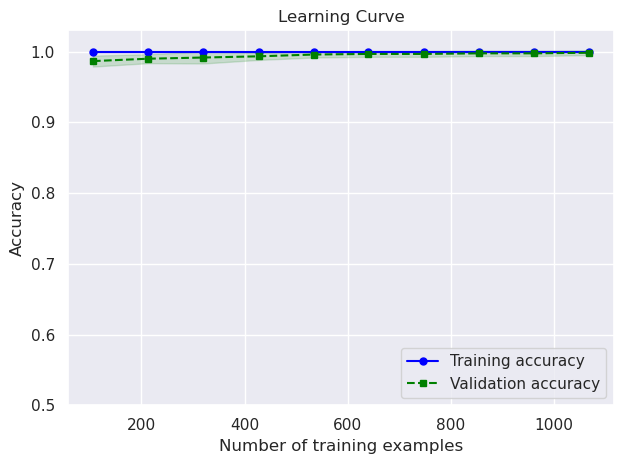

In [29]:
pipe_svc = make_pipeline(StandardScaler(), SVC(kernel="linear", C=1.0))
                                           
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=best_model,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=-1)

#print(train_sizes)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid(True)
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title("Learning Curve")
plt.ylim([0.5, 1.03])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

Create confusion matrix:

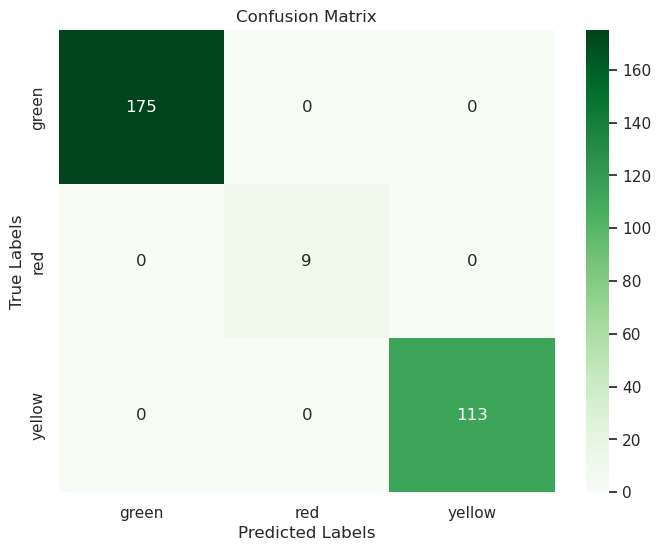

In [30]:
y_pred = best_model.predict(X_test)
confmat = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(confmat, annot=True, fmt='d', cmap='Greens', xticklabels=np.unique(['red', 'yellow', 'green']), yticklabels=np.unique(['red', 'yellow', 'green']))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
labels = ['red', 'yellow', 'green']
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       175
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00       113

    accuracy                           1.00       297
   macro avg       1.00      1.00      1.00       297
weighted avg       1.00      1.00      1.00       297



Which corresponds to labels of

```
              precision    recall  f1-score   support

        Red       1.00      1.00      1.00       175
        Yellow    1.00      1.00      1.00         9
        Green     1.00      1.00      1.00       113

    accuracy                           1.00       297
   macro avg       1.00      1.00      1.00       297
weighted avg       1.00      1.00      1.00       297
```

Now we save the model as a `.pkl` file to be used later. This can be uncommented if undesired.

In [ ]:
# if not os.path.exists('models'):
#     os.mkdir('models')

# with open('models/svm_model.pkl', 'wb') as f:
#     pickle.dump(best_model, f)